# Evaluate the Single-Linkage Ascendant Hierarchical Clustering

Here we assess the potential of the clustering algorithm CAH single-linkage for the clustering of the images, with an example on curved rows, where DBSCAN fails sometimes.

## Rows clustering with CAH

Results on the rows: we could abandon this clustering method for rows for three reasons
1. The clustering results are not better with this method compared with DBSCAN for example
2. We have to give the number of cluster a priori (or alternatively a distance threshold)
3. The execution is prohibitive (200 sec for half and image).

In [1]:
import imageio
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd
import time

from skimage.morphology import skeletonize, binary_dilation, binary_erosion, binary_closing
from skimage import data
from skimage.util import invert

from sklearn.cluster import AgglomerativeClustering


Imported image, expected number of clusters : 18


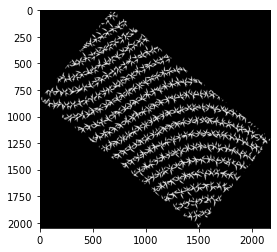

In [2]:
path = "D:/Documents/IODAA/Fil Rouge/Resultats/dIP_vs_dIR_curved/densite=7/027_54_analysis/Output/Session_1/Otsu_R/OTSU_R_027_054_3_300.jpg"
save_img_path = "D:/Documents/IODAA/Fil Rouge/Resultats/dIP_vs_dIR_curved/densite=7/Analysis/027_024_CAH1.svg"

image = imageio.imread(path)
plt.imshow(image)
nb_clusters = 18
print(f"Imported image, expected number of clusters : {nb_clusters}")

In [3]:
def threshold(img, threshold=127):
    ar = np.ones(img.shape)
    for i in range(ar.shape[0]):
        for j in range(ar.shape[1]):
            # for k in range(array.shape[2]):
            if img[i, j] < threshold:
                ar[i, j] = 0
    return ar

In [31]:
subsample = 100000
n_clusters = 18
array = threshold(np.asarray(image[:, :, 1]))
positive_pixels = np.argwhere(array == 1)
positive_pixels = positive_pixels[:subsample]

In [32]:
print(positive_pixels.shape)

(100000, 2)


In [52]:
t0 = time.time()
model = AgglomerativeClustering(linkage="single",
                                distance_threshold=10,
                                n_clusters=None)
model.fit(positive_pixels)
elapsed_time = time.time() - t0

23


Text(0.5, 0.98, 'cluster number: 18')

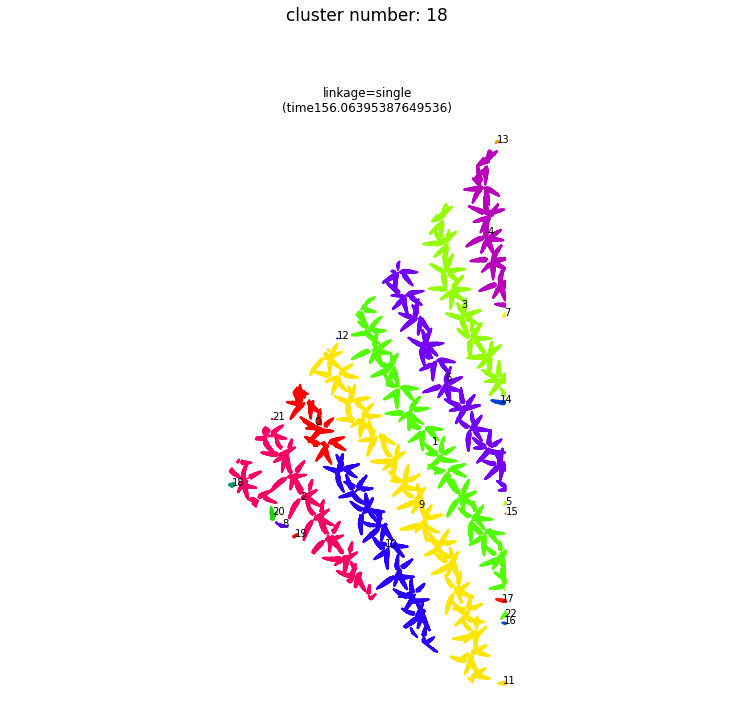

In [53]:
txts = []
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# cluster labels
for i in set(model.labels_):
    xtext = np.median(positive_pixels[model.labels_ == i, 0])
    ytext = np.median(positive_pixels[model.labels_ == i, 1])
    txt = ax.text(xtext, ytext, str(i))
    # txt.set_path_effects(
    #    [PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
    # )
    txts.append(txt)

print(len(set(model.labels_)))

# n_cluster = 2

# # text
# xtext = np.median(positive_pixels[model.labels_ == n_cluster, 0])
# ytext = np.median(positive_pixels[model.labels_ == n_cluster, 1])
# txt = ax.text(xtext, ytext, str(n_cluster))

# plot
ax.scatter(positive_pixels[:, 0], positive_pixels[:, 1], s=1, c=model.labels_, cmap="prism")
# ax.scatter(positive_pixels[:, 0], positive_pixels[:, 1], s=1, c=model.labels_ * 10, cmap="Pastel1")
plt.title(f'linkage=single\n(time{elapsed_time})',
        fontdict=dict(verticalalignment='top'))
plt.axis('equal')
plt.axis('off')

plt.subplots_adjust(bottom=0, top=.83, wspace=0,
                left=0, right=1)
# plt.suptitle(f'n_cluster={n_clusters}', size=17)
plt.suptitle(f"cluster number: {n_clusters}", size=17)

# save
# plt.savefig(save_img_path)

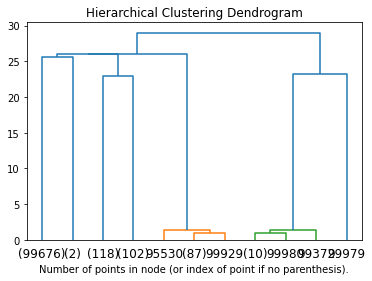

In [46]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Plant clustering with CAH

Here we first cluster the rows using DBSCAN (which is our baseline) and then try to detect the plants with CAH. This could improve the time complexity and provide an alternative to the Fuzzy clustering algorithm which is our current approach but is quite slow.

#### Rows clustering with CAH

In [4]:
from sklearn.cluster import DBSCAN

In [5]:
array = threshold(np.asarray(image[:, :, 1]))
positive_pixels = np.argwhere(array == 1)

In [6]:
t0 = time.time()
model = DBSCAN(eps=8, min_samples=15)
model.fit(positive_pixels)
dbscan_clustering_time = time.time() - t0
print(f"Number of identified clusters : {len(set(model.labels_))}")

Number of identified clusters : 61


Text(0.5, 0.98, 'Number of clusters : 61')

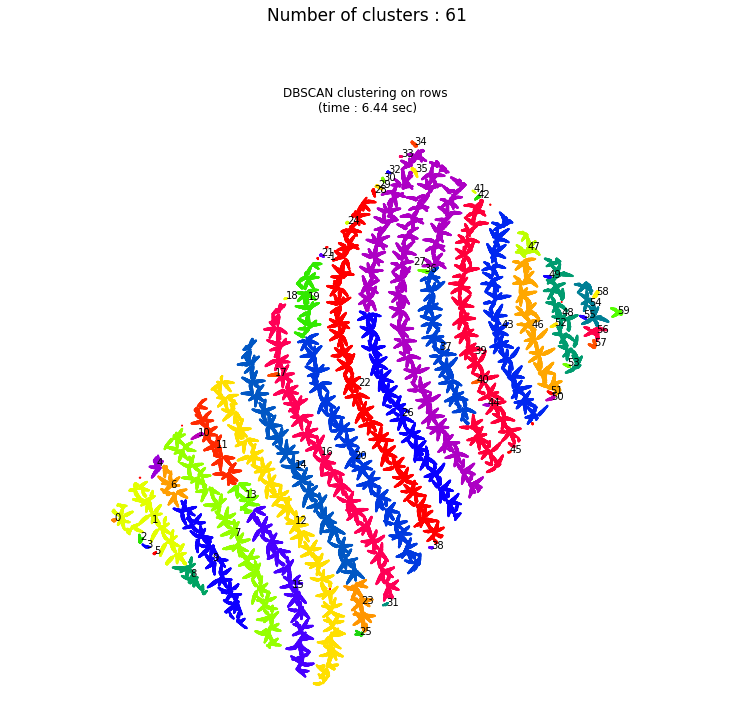

In [7]:
txts = []
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# cluster labels

for i in set(model.labels_):
    xtext = np.median(positive_pixels[model.labels_ == i, 0])
    ytext = np.median(positive_pixels[model.labels_ == i, 1])
    txt = ax.text(xtext, ytext, str(i))
    txts.append(txt)

# n_cluster = 2

# # text
# xtext = np.median(positive_pixels[model.labels_ == n_cluster, 0])
# ytext = np.median(positive_pixels[model.labels_ == n_cluster, 1])
# txt = ax.text(xtext, ytext, str(n_cluster))

# plot
ax.scatter(positive_pixels[:, 0], positive_pixels[:, 1], s=1, c=model.labels_, cmap="prism")
# ax.scatter(positive_pixels[:, 0], positive_pixels[:, 1], s=1, c=model.labels_ * 10, cmap="Pastel1")
plt.title(f'DBSCAN clustering on rows \n(time : {round(dbscan_clustering_time, 2)} sec)',
            fontdict=dict(verticalalignment='top'))
plt.axis('equal')
plt.axis('off')

plt.subplots_adjust(bottom=0, top=.83, wspace=0,
                left=0, right=1)
# plt.suptitle(f'n_cluster={n_clusters}', size=17)
plt.suptitle(f"Number of clusters : {len(set(model.labels_))}", size=17)

## Plants clustering with CAH on the identified rows

In [ ]:
clustered_plants = []

dbscan_model = model

init_time = time.time()

# for i in range(len(set(model.labels_))):
for i in range(len(set(dbscan_model.labels_))):
    # retrieve each row
    cluster_pixels = positive_pixels[dbscan_model.labels_ == i]
    if cluster_pixels.shape[0] > 0:

#         print(f"Number of points in cluster {i} : {cluster_pixels.shape[0]}")

        # cluster the plants using CAH
        t0 = time.time()
        cah_model = AgglomerativeClustering(linkage="ward",
                                        distance_threshold=5,
                                        n_clusters=None)
        cah_model.fit(cluster_pixels)
        elapsed_time = time.time() - t0

    #     indices = model.labels_.tolist()
    #     clustered_plants.extend(indices)
        # save row idx and plant idx
        for plant in cah_model.labels_:
            clustered_plants.append((i, plant))

#         print(f"CAH took {round(elapsed_time, 2)} seconds for cluster {i} with {cluster_pixels.shape[0]} pixels")
    
tot = time.time()
print(f"Total time : {tot - init_time}")
    
print(len(clustered_plants))
clustered_plant_indices = np.array(clustered_plants)

In [ ]:
print(clustered_plant_indices.shape)

In [ ]:
txts = []
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

nb_points = clustered_plant_indices.shape[0]
pixels_subset = positive_pixels[:nb_points]

# cluster labels
for i in np.unique(clustered_plant_indices[:, 0]):
    row_plants_indices = clustered_plant_indices[clustered_plant_indices[:, 0] == i]
    rows_pixels = pixels_subset[clustered_plant_indices[:, 0] == i]
    for j in np.unique(row_plants_indices[:, 1]):
        xtext = np.median(rows_pixels[row_plants_indices[:, 1] == j, 0])
        ytext = np.median(rows_pixels[row_plants_indices[:, 1] == j, 1])
        txt = ax.text(xtext, ytext, str(i))
        # txt.set_path_effects(
        #    [PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()]
        # )
        txts.append(txt)

print(len(set(model.labels_)))

# n_cluster = 2

# # text
# xtext = np.median(positive_pixels[model.labels_ == n_cluster, 0])
# ytext = np.median(positive_pixels[model.labels_ == n_cluster, 1])
# txt = ax.text(xtext, ytext, str(n_cluster))

# plot
n_clusters = np.unique(clustered_plant_indices).shape[0]
ax.scatter(positive_pixels[:nb_points, 0], positive_pixels[:nb_points, 1], s=1, c=clustered_plant_indices[:, 1], cmap="prism")
# ax.scatter(positive_pixels[:, 0], positive_pixels[:, 1], s=1, c=model.labels_ * 10, cmap="Pastel1")
plt.title(f'linkage on plants = single\n(time: {round(tot, 2)} sec)',
            fontdict=dict(verticalalignment='top'))
plt.axis('equal')
plt.axis('off')

plt.subplots_adjust(bottom=0, top=.83, wspace=0,
                left=0, right=1)
# plt.suptitle(f'n_cluster={n_clusters}', size=17)
plt.suptitle(f"cluster number: {n_clusters}", size=17)

# save
# plt.savefig(save_img_path)